Through this combination, you can learn how to sample **un-balance data** and how to handle data that have many categories. There are a variety of ways. Here. There are various method we can check that are not used in Titanic.

# Contents of notebook


**1. Visual inspection of your data**

**2. Defining the metadata** 

**3. Descriptive statistics** 

**4. Handling imbalanced classes** 

**5. Data quality checks** 

**6. Exploratory data visualization** 

**7. Feature engineering**

**8. Feature selection** 

**9. Feature scaling** 

# 1. Visual inspection of your data 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', 100)

* **SimpleImputer**: Imputation transformer for completing missing values.
* **PolynomialFeatures**: 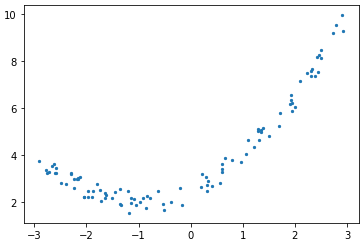
 
The above data cannot be solved by general linear regression because the distribution of the data is curved. (Non-linear)
Therefore, we use polynomial regression. Polynomial regression is a method of training nonlinear data with added characteristics as a linear regression model by adding a square of each characteristic to the data when the shape between the data is nonlinear as shown above.
* **SelectFromModel**: Select attributes based on user-specified thresholds after model training ends
* **RandomForestClassifier**: A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

# Loading Data 

## Data at first sight 

Here is an exception of the data description for the competition: 

* Features that belong to similar groupings tagged as such in the feature names(e.g. ind, reg, car, calc)
* Feature names inculde the postfix bin to indicate binary features and cat to indicate categorical features.
* Features without these designations are either continuous or ordinal. 
* Values of -1 indicate that the feature was missing from the observation 
* The target columns signifies whether or not a claim was filed for that policy holder 

"Ind" is related to individual or driver, "reg" is related to region, "car" is related to car itself and "calc" is an calculated feature.

This is the important information to get us started. let's have a quick look at the first and last rows to confirm all of this. 


In [ ]:
train = pd.read_csv('../input/porto-seguro-safe-driver-prediction/train.csv')
test = pd.read_csv('../input/porto-seguro-safe-driver-prediction/test.csv')

In [ ]:
train.head()

In [ ]:
train.shape

In [ ]:
train.info()

By using the info() method, we once again confirmed that the type of data is integer or floatd. The info() method determines that there are no missing values. As I mentioned earlier, the missing values are replaced by -1. We will deal with it later.

You must check the data column before you start the compilation.

#### We indeed see the following 
 
* Binary variables 
* Categorical variables of which the category values are integers
* Other variable with integer or float values 
* Variables with -1 representing missing values 
* The target variable and an ID variable 

In [ ]:
train.shape

In [ ]:
test.shape

The test is 58 because of course there is no target value.

In [ ]:
train.drop_duplicates()   
train.shape

**.drop_duplicates()** = This means that if there is a duplicate column, it will be deleted.

We can check there is No duplicate rows. 

So later on we can create dummy variables for the 14 categorical variables(=nunique data). The bin variables are already binary and do not need dummification.
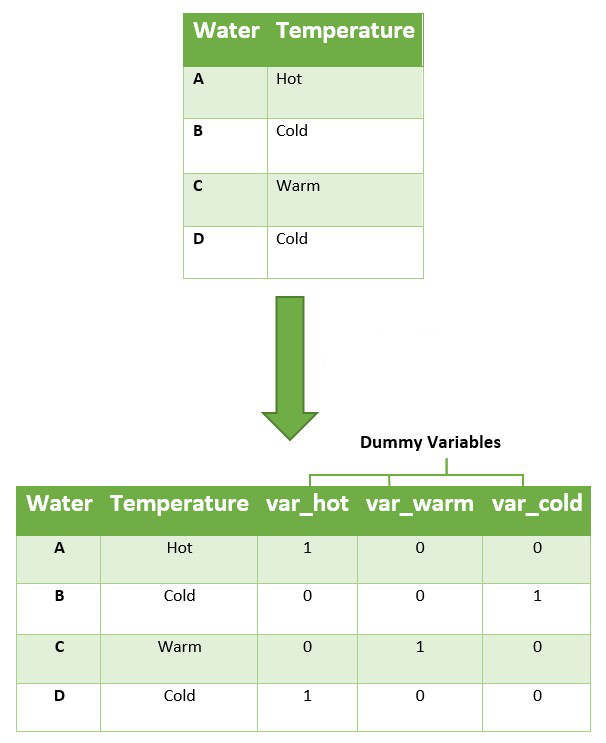

**'Dummy variable'** allows the computer to recognize the values of categorical materials when performing statistics or mechanical learning by entering values as '1' if they fall into the category and '0' if not.

In [ ]:
train.info()

Again, with the info() method we see that the data type is integer or float. No null values are present in the data set. That's normal because missing values are replaced by -1. We'll look into that later.. 

# 2. Defining the metadata

 **'Metadata'** is defined as the data providing information about one or more aspects of the data; it is used to summarize basic information about data which can make tracking and working with specific data easier.

To facilitate the data management, we'll store meta-information about the variables in a DataFrame. 

This will be helpful when we want to select specific variables for analysis, visualization, modeling.

* **role**: input, ID, target
* **level**: nominal, interval, ordinal, binary
* **keep**: True or False
* **dtype**: int, float, str

If you look at the code below, we are grouping by column. For example, the Label Column, Target, is defined as Target and input for the column to be used for analysis, and a column to record the usage of each variable is created through the "Keep" column to organize which column to write about in the train.

In [ ]:
#Create a frame that stores multiple data 
data = []
for f in train.columns:
    #Define the role
    if f == 'target':
        role = 'target'
    elif f =='id':
        role = 'id'
    else:
        role = 'input'
    
    #Define the level 
    if 'bin' in f or f =='target':
        level = 'binary'
    elif 'cat' in f or f == 'id':
        level = 'nominal'
    elif train[f].dtype == 'float64':
        level = 'interval'
    elif train[f].dtype == 'int64':
        level = 'ordinal'
    
    #Define the keep
    keep = True
    if f =='id':
        keep = False
    
    #Defining the dtype
    dtype = train[f].dtype
    
    #Creating a Dict that contains all the metadata for the variable 
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns = ['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace=True)

In [ ]:
meta

For example, extract the index of data with a level of nominal.

In [ ]:
meta.loc[(meta.level == 'nominal') & (meta.keep)].index

Below the number of variable per role and level are displayed 

In [ ]:
pd.DataFrame({'count' : meta.groupby(['role', 'level'])['role'].size()}).reset_index()

## Descriptive Statistics 
: is a summary statistic that quantitatively describes or summarizes features from a collection of information
 
We can also apply the describe method on the dataframe. However, it doesn't make much sense to calculate the mean, std,on categorical variables and the id variable. We'll explore the categorical variables visually later.

Thanks to our meta file we can easily select the variables on which we want to compute the descriptive statistics. To keep things clear, we'll do this per data type.

### 1_Interval variables 

In [ ]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
train[v].describe()

**reg variables**
* only ps_reg_03 has missing values
* the range (min to max) differs between the variables. We could apply scaling (e.g. StandardScaler), but it depends on the classifier we will want to use.

**car variables**
* ps_car_12 and ps_car_15 have missing values
* again, the range differs and we could apply scaling.

**calc variables**
* no missing values, this seems to be some kind of ratio as the maximum is 0.9
* all three _calc variables have very similar distributions

Overall, we can see that the range of the interval variables is rather small. Perhaps, some transformation is already applied in order to anonymize the data.

### 2_Ordinal variables

In [ ]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
train[v].describe()

* Only one missing variable: ps_car_11
* We could apply scaling to deal with the different ranges

### 3_Binary variables

In [ ]:
v = meta[(meta.level == 'binary') & (meta.keep)].index
train[v].describe()

* A priori(**'target'**) in the train data is 3.645%, which is strongly **imbalanced**.
* From the means we can conclude that for most variables the value is zero in most cases.

# 4. Handling imbalanced classes

check out the target values 

In [ ]:
features = train.drop(['id','target'], axis=1).values
targets = train.target.values

ax = sns.countplot(x = targets ,palette="rocket_r")
sns.set(font_scale=1.5)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(10,5)
ax.set_ylim(top=700000)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(targets)), (p.get_x()+ 0.3, p.get_height()+10000))

plt.title('Distribution of 595212 Targets')
plt.xlabel('Initiation of Auto Insurance Claim Next Year')
plt.ylabel('Frequency [%]')
plt.show()

The plot shows that:
* the target is imbalanced
* high bias is expected to 0
* class weight has to be balanced on training

As we mentioned above the proportion of records with target=1 is far less than target=0. This can lead to a model that has great accuracy but does have any added value in practice. Two possible strategies to deal with this problem are:

For example, 96 out of 100 values are zero and only 4 have value one. Then, all of them might be called zero without making models, and the accuracy is 95 percent. In other words, it is important to get a good one, which makes the balance strange. Its accuracy is practically zero percent. Because all 1 is said to be zero, the accuracy is zero percent. Therefore, acuracy should not be used, so 'gini' and 'rucac' should be used.

Two possible strategies to deal with this probelm are:

* 1) **Oversampling records with target** = 1
* 2) **Undersampling records with targe**t = 0

**Oversampling** is the process of learning by adding more samples to existing samples. For example, there are currently only four target values(=1), which makes to raised to 50. It is to proceed with learning on sound.

The undersampling is rather diminishing. Undersampling has a target value of 96, which is reduced to 50. 

We are going to use **undersampling**.  

In [ ]:
desired_apriori=0.10

# Get the indices per target value
idx_0 = train[train.target == 0].index
idx_1 = train[train.target == 1].index

# Get original number of records per target value
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

# Calculate the undersampling rate and resulting number of records with target=0
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# Randomly select records with target=0 to get at the desired a priori
undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

# Construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

# Return undersample data frame
train = train.loc[idx_list].reset_index(drop=True)

Code to find the undersampling rate 
*undersampled_nb_0 = int(undersampling_rate*nb_0)

During the Descriptive Stats verification process, too many cases of Target == 0 were found for the Label Column Target column compared to Target == 1, so under sampling was performed to match the same ratio.

The appropriate number of records is calculated by applying the Under-sampling Rate to the number of class records each biased. We then randomly screen the index by that number and then finally adjust the Train Dataset so that the data remains 1:1 per each class.

In [ ]:
train['target'].value_counts

In [ ]:
train_target = train[train['target'] ==0]
train_target.value_counts

In [ ]:
train_target2 = train[train['target'] ==1]
train_target2.value_counts

* target ==0 : 195246
* target ==1 : 21694

# 5. Data quality checks

### Checking missing values
Missings are represented as -1 

In [ ]:
vars_with_missing = []

for f in train.columns:
    missings = train[train[f] == -1][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings / train.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))        
        

We filled the continuous values with the average values and the ordinal values with the most common values. The missing value of the data should also not be filled carelessly. There are ways to fill miss values by grouping them in more detail, or to learn from features that do not have miss values at all and fill them with them. 

Depending on how you fill this missing value, you should be careful because it may be a factor in creating a bias.

* **ps_car_03_cat and ps_car_05_cat** have a large proportion of records with missing values. Remove these variables.
* For the other categorical variables with missing values, we can leave the missing value -1 as such.
* **ps_car_11** (ordinal) has only 1 records with misisng values. Replace by the mode.
* **ps_reg_03** (continuous) has missing values for 18% of all records. Replace by the mean.
* **ps_car_14** (continuous) has missing values for 7% of all records. Replace by the mean.

But you can't erase it like this. We need to check it before we fill out the missing values. Missing values may be meaningful, so you should check them.

There are some important meaning in missing value values in this way, so you should check them out.

In [ ]:
#you can see that it doesn't mean much.
train[['ps_car_03_cat', 'target']].groupby('ps_car_03_cat').mean()

In [ ]:
#Dropping the variables with too many missing values 
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(vars_to_drop, inplace = True, axis= 1)
meta.loc[vars_to_drop, 'keep'] = False #Updating the meta 

In [ ]:
#Imputing with the mean or mode 
#IMP = missing values(=-1)
mean_imp = SimpleImputer(missing_values = -1, strategy = 'mean')
mode_imp = SimpleImputer(missing_values = -1, strategy = 'most_frequent')

train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11'] = mode_imp.fit_transform(train[['ps_car_11']]).ravel()

### Checking the cardinality of the categorical variables 
* Cardinality is an indicator of the duplicate numbers in a particular column for the entire row.
* High redundancy(중복도) means low cardinality, and low redundancy means high cardinality.
* Cardinality should be understood as a relative concept.

Thus, cardinality refers to the number of different values within the variable. We are going to dummy up the categories later, and we need to check how many other values there are in them.Because if there are many values, a lot of dummy variables can be made.

In [ ]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index 
sum = 0

for f in v: 
    dist_values = train[f].value_counts().shape[0]
    sum += dist_values
    print('Variable {} has {} distinct values'.format(f, dist_values))

밑에 노이즈를 넣어주면 너무 디스크리트 하니깐?? 디스크리트가 근데 몬지 잘모르겠음 , 노이즈 값으로 맥시멈 값을 1을 넘지 않게해준닥 하는데 이것도 무슨 소리인지는 잘 모르겠다. 노이즈를 넣어줘서 디스크리트 하지않고 컨티뉴어스 한 값을 만들어주는 것이다. 일단 encoding이 무엇인지 구글에서 한번 찾아보도록 하기. 

* When working with high cardinality categorical features it is hard for a model to put every small category into a separate bucket, but if a lot of small categories can be put in one bin together based on their mean target value, then trees can learn way faster. 
* Less bias, since now lavels have more meaning: closer labels mean closer categories in terms of the mean target variable. 

여기 밑에 코드는 하나씩 뜯어보기  **너무 Value가 많은 Categorical Variables를 가공하는 과정**

In [ ]:
# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):

    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [ ]:
def add_noise(series, noise_level):
    return series * (1+ noise_level * np.random.randn(len(series)))

Define a function that causes Noise.

The series values and noise levels are taken as variables.
Returns the series (1 + random number sampled from the noise level standard normal distribution).

Let's start with the target encode function asset.

Now, in fact, data are said to contain most of the strange data such as noise, and this process is now a partial noise-giving method to create a model that does not shake even with such noise. That is, it is the same vaccination that produces antibodies by exposing the virus to the body as part of it.
Using this method of putting noise into data as part of it is now said to be more powerful than reducing parameter values as we proceed with the learning. 

For example, if you proceed with classification, if the value is now 10,0, then it will be 0.8, 0.1, 0.1, 0.1, more specific and smoother labeling ???It has the effect of doing it (although I don't really understand how to soften the labeling here) but it still works!)
In conclusion, one of the ways to improve the efficiency of the model is just used by sensing or bagging.

In [ ]:
assert len(train["ps_car_11_cat"]) == len(train['target'])
assert train["ps_car_11_cat"].name == test["ps_car_11_cat"].name

The trn_series we're going to use is train ['ps_car_11_cat'], and target is train['target'].
Verify that the two series are the same length, and that train ['ps_car_11_cat'] and test ['ps_car_11_cat'] have the same name.

In [ ]:
temp = pd.concat([train['ps_car_11_cat'], train['target']], axis=1)
print(temp)

Let's concat the two series based on the column and save them as a variable named temp.

In [ ]:
averages = temp.groupby(train['ps_car_11_cat'].name)[train['target'].name].agg(['mean', 'count'])
print(averages)

Group the values in the target column by train ['ps_car_11_cat'] and store the values that the mean and count functions applied to the variables.

The averages function is,
Contains target average and number of times information for each Value

In [ ]:
smoothing = 1 / (1 + np.exp(-(averages["count"] - 100) / 10))
print(smoothing)

Smoothing is usually done to help us better see patterns, trends for example, in time series. Generally smooth out the irregular roughness to see a clearer signal. 

In [ ]:
prior = train['target'].mean()

averages[train['target'].name] = prior * (1 - smoothing) + averages["mean"] * smoothing
print(averages)

The prior value is the average value of the train ['target']. Previously, we set the ratio of 0 to 1 to 9:1 through undersampling, so the priority value is 0.1.

Then add a column named target to the targets. Values are converted using Smoothing.

In [ ]:
averages.drop(['mean', 'count'], axis=1, inplace=True)

It seems that only the required value is Smoothed. Use drop to subtract mean and count.

In [ ]:
ft_trn_series = pd.merge(
        train['ps_car_11_cat'].to_frame(train['ps_car_11_cat'].name),
        averages.reset_index().rename(columns={'index': train['target'].name, train['target'].name: 'average'}),
        on=train['ps_car_11_cat'].name,
        how='left')['average'].rename(train['ps_car_11_cat'].name + '_mean').fillna(prior)

print(ft_trn_series)

Import the ps_car_11_cat series into the data frame as to_frame.
Initializes the index of the aggregates, and renames the index values to target, column names to target.
Specify the on and how values to merge.
Rename the series to ps_car_11_cat_mean and replace the missing values with the prior values.

In [ ]:
ft_trn_series.index = train["ps_car_11_cat"].index 

Aligns indexes of newly created series with existing training data series indexes


In [ ]:
ft_tst_series = pd.merge(test['ps_car_11_cat'].to_frame(test['ps_car_11_cat'].name),
                              averages.reset_index().rename(columns={'index' : 'target', 'target' : 'averages'}),
                              on=test['ps_car_11_cat'].name,
                              how='left')['averages'].rename(train['ps_car_11_cat'].name + '_mean').fillna(prior)

ft_tst_series.index = test["ps_car_11_cat"].index

The previous work in the train data is also carried out in the test data.

In [ ]:
add_noise(ft_trn_series, 0.01), add_noise(ft_tst_series, 0.01)

Takes advantage of the add_noise function that you initially defined to return values that caused noise.
Here's a summary of the processes that we've done in the function.

1) Define add_noise function to create noise

2) Verify that the len of the train data and target data are the same, and that the test data and train data have the same name.

3) train series and target series concat

4) Calculate mean and count by value and save as Average
 
5) Calculate Smoothing

6) Define the prior as the average value of the target data.

7) Smoothing the average of each value that was previously proceeded and remove unnecessary mean and count
 
8) Define a new series (trn/test_cat_mean) with values from Averages Returns a series with the initial definition of add_noise

In [ ]:
train_encoded, test_encoded = target_encode(train["ps_car_11_cat"], 
                             test["ps_car_11_cat"], 
                             target=train.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)
    
train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis=1, inplace=True)
meta.loc['ps_car_11_cat','keep'] = False  # Updating the meta
test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

# 6. Exploratory data visualization

### Categorical Variables
Categorical variables and the proportion of customers with target = t

In [ ]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    #plt.figure()
    fig, ax = plt.subplots(figsize=(20,10))
    #Calculate the percentage of target=1 per category value
    cat_perc = train[[f,'target']].groupby([f],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
   
    # Bar plot
    # Order the bars descending on target mean
    sns.barplot(ax=ax, x=f, y='target', data=cat_perc, order=cat_perc[f])
    plt.xlabel('%target')
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major')
    plt.show();   

The bar graphs show the variables with missing values. We replaced the missing values earlier, but we didn't replace the categories separately. It may be a better way to see missing values as separate category values than replacing them with the least frequently values.

This is because customers with missing values have a much higher target average than other values!

As we can see from the variables with missing values, it is a good idea to keep the missing values as a separate category values, instead of replacing them by them by the mode for instance. The customers with a missing value appear to have a much higher probability to ask for an insurance claim. 

### Interval Variables
**Checking the correlations between interval variables.**

A heatmap is a good way to visualize the correlation between variables. 

In [ ]:
def corr_heatmap(v):
    correlations = train[v].corr()

    # Create color map ranging between two colors
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(13,13))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    
    plt.show();
    
v = meta[(meta.level == 'interval') & (meta.keep)].index
corr_heatmap(v)

There are a strong correlation between the variable. 

* ps_reg_02 and ps_reg_03 (0.7)
* ps_car_12 and ps_car13 (0.67)
* ps_car_12 and ps_car14 (0.58)
* ps_car_13 and ps_car15 (0.67)

Seaborn has some handy plots to visualize the (linear) relationship between variables. We could use a pairplot to visualize the relationship between the variables. But because the heatmap already showed the limited number of correlated variables, we'll look at each of the highly correlated variables separately.
**NOTE**: I take a sample of the train data to speed up the process. 

Use a sample of train data to speed up the process.

In [ ]:
#Sample 10% of data from train data
s = train.sample(frac = 0.1)

**ps_reg_02 and ps_reg_03**

As the regression line shows, there is a linear relationship between these variables. Thanks to the hue parameter we can see that the regression lines for target=0 and target=1 are the same.

In [ ]:
sns.lmplot( 'ps_reg_02', 'ps_reg_03', data=s, hue='target', palette='rocket_r', height=8, scatter_kws = {'alpha': 0.3}) #여기서 alpha는 투명도를 말해주는 것이다. 
plt.show()

**ps_car_12 and ps_car_13**

In [ ]:
sns.lmplot('ps_car_12', 'ps_car_13', data=s, hue='target', palette='rocket_r', height=8, scatter_kws = {'alpha': 0.3}) #여기서 alpha는 투명도를 말해주는 것이다. 
plt.show()

**ps_car_12 and ps_car_14**

In [ ]:
sns.lmplot('ps_car_12', 'ps_car_14', data=s, hue='target', palette='rocket_r', height=8, scatter_kws = {'alpha': 0.3}) #여기서 alpha는 투명도를 말해주는 것이다. 
plt.show()

**ps_car_13 and ps_car_15**

In [ ]:
sns.lmplot('ps_car_15', 'ps_car_13', data=s, hue='target', palette='rocket_r', height=8, scatter_kws = {'alpha': 0.3}) #여기서 alpha는 투명도를 말해주는 것이다. 
plt.show()

Allright, so now what? How can we decide which of the correlated variables to keep? We could perform **Principal Component Analysis (PCA)** on the variables to reduce the dimensions. In the AllState Claims Severity Competition I made this kernel to do that. But as the number of correlated variables is rather low, we will let the model do the heavy-lifting. 

In conclusion, the essence of PCA is dimensionality reduction.

It's not the original data, it's the dimensions are reduced.

Converted data == using main components

It means that it will proceed with analysis or modeling.

### Checking the correlations between ordinal variables

In [ ]:
def corr_heatmap(v):
    correlations = train[v].corr()

    # Create color map ranging between two colors
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(16,16))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    
    plt.show();
    

v = meta[(meta.level == 'ordinal') & (meta.keep)].index
corr_heatmap(v)

Ordinal variables do not appear to have much correlation. On the other hand, you can see what the distribution will look like when grouping into target values.

# 7. Feature engineering

### Creating dummy variables
The values of the categorical variable do not represent any order or magnitude. 
For example, category 2 is not twice the value of category 1. Therfore we can create dummy variables to deal with that.
We drop the first dummy variables as this information can be derived from the other dummy variable generated for the categories of the orginal varible. 

In [ ]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index
print('Before dummification we have {} variables in train'.format(train.shape[1]))

train = pd.get_dummies(train, columns=v, drop_first=True)
print('After dummification we have {} variables in train'.format(train.shape[1]))

So creating dummy variables adds 52 variables to the training set. 

## Creating Interaction Variables

In [ ]:
v = meta[(meta.level == 'interval') & (meta.keep)].index

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
interactions = pd.DataFrame(data=poly.fit_transform(train[v]), columns=poly.get_feature_names(v))
interactions.drop(v, axis=1, inplace=True)  # Remove the original columns, 기존에 있던것들은 빼버린다는 의미 
# Concat the interaction variables to the train data
print('Before creating interactions we have {} variables in train'.format(train.shape[1])) #이건 붙이기 전
train = pd.concat([train, interactions], axis=1)
print('After creating interactions we have {} variables in train'.format(train.shape[1])) #이건 붙이기 후 , 그리고  axis 를 옆으로 부쳐야지 좀 보기 좋다. 

This adds extra interaction variables to the train data. Thanks to the get_feature_names method we can assign column names to thes new variable. 

# 8. Feature selection

## Removing Features with low or zero variance 

* Personally, I prefer to let the classifier algorithm chose which features to keep. But there is one thing that we can do ourselves. 
* That is removing features with no or a very low variance. Sklearn has a handy method to do that: VarianceThreshold. By default it removes features with zero variance. 
* This will not be applicable for this competition as we saw there are no zero-variance variables in the previous steps. 
* But if we would remove features with less than 1% variance, we would remove 31 variables.

So what they're saying now is that if the variation is small, there's less information you can get from the feature. We'll give you this information, but you and I choose here. These calculations are all possible at sklearn, but they are meaningless because there is no zero value. That's why we're setting the threshold. One percent means they will be erased.

In [ ]:
selector = VarianceThreshold(threshold=.01)
selector.fit(train.drop(['id', 'target'], axis=1)) # Fit to train without id and target variables

f = np.vectorize(lambda x : not x) # Function to toggle boolean array elements, 이것은 한번 ㄷ따로 빼서 써보면 어떤 의미인지 알수 있다. (일단 밑에 뜯어보면서 보기)


v = train.drop(['id', 'target'], axis=1).columns[f(selector.get_support())] #일단 selector.get_support이거는 true인지 false인지 나타내주는 것이다. 여기서 합을 한번에 대입해버리면 
print('{} variables have too low variance.'.format(len(v)))
print('These variables are {}'.format(list(v)))

We would lose rather many variables if we would select based on variance. But because we do not have so many variables, we'll let the classifier chose. For data sets with many more variables this could reduce the processing time.

Sklearn also comes with other feature selection methods. One of these methods is SelectFromModel in which you let another classifier select the best features and continue with these. Below I'll show you how to do that with a Random Forest. 

### Selecting features with a Random Forest and SelectFromModel
Here we'll base feature selection on the feature importance of a random forest. With Sklearn's SelectFromModel you can then specify how many variables you want to keep. You can set a threshold on the level of feature importance manually. But we'll simply select the top 50% best variables.


In [ ]:
#Training start 
X_train = train.drop(['id', 'target'], axis= 1)
y_train = train['target']

In [ ]:
feat_labels = X_train.columns

#just use 10 n_estimators since it takes too mich time 
rf = RandomForestClassifier(n_estimators=10, random_state=0, n_jobs=-1)
 
rf.fit(X_train[:1000], y_train[:1000])
importances = rf.feature_importances_
#sorting
indices = np.argsort(rf.feature_importances_)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]], importances[indices[f]]))


The results will come in important order. However, we have set the n_estimator value here at 10, so the results are not produced. 

With SelectFromModel we can specify which prefit classifier to use and what the threshold is for the feature importances. With the get_support method we can then limit the number of variables in the train data.


It means that we will be able to decide on a model and how many to leave.

In [ ]:
sfm = SelectFromModel(rf, threshold='median', prefit=True)  #prefit이것은 rf이렇게 이미 학습한 모델을 사용하겠다는 것을 의미해주는 코드이다. 
print('Number of features before selection: {}'.format(X_train.shape[1]))
n_features = sfm.transform(X_train).shape[1]
print('Number of features after selection: {}'.format(n_features))
selected_vars = list(feat_labels[sfm.get_support()])


In [ ]:
train = train[selected_vars + ['target']]

In [ ]:
train.shape 

# 9. Feature scaling

As mentioned before, we can apply standard scaling to the training data. Some classifiers perform better when this is done.

In [ ]:
scaler = StandardScaler()
scaler.fit_transform(train.drop(['target'], axis=1))

# The End

# Reference

I made more explanation based on 

https://www.kaggle.com/bertcarremans/data-preparation-exploration.

https://www.youtube.com/watch?v=r26Ar4AiwVI&t=1736s